In [25]:
import os
import librosa
import numpy as np
import librosa.display
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity

In [26]:
def extract_peaks(audio_path):
    """Loads an audio file, extracts the shock component, and returns the peak moments in seconds."""
    y, sr = librosa.load(audio_path)
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    pre_max_val = 3
    post_max_val = 3
    pre_avg_val = 5
    post_avg_val = 5
    delta_val = 1.
    wait_val = 5

    peak_frames = librosa.util.peak_pick(
        onset_env,
        pre_max=pre_max_val,
        post_max=post_max_val,
        pre_avg=pre_avg_val,
        post_avg=post_avg_val,
        delta=delta_val,
        wait=wait_val
    )
    peak_times = librosa.frames_to_time(peak_frames, sr=sr)
    duration = librosa.get_duration(y=y, sr=sr)
    return peak_times, duration

def create_feature_vector(peak_times, duration):
    """Creates a normalized feature vector from the peak moments."""
    first_peak = peak_times[0]
    feature_vector = (peak_times - first_peak) / duration if duration > 0 else (peak_times - first_peak)
    return feature_vector

friendly_dir = r'knock_data_clean\friend_knock'
enemy_dir = r'knock_data_clean\enemy_knock'

friendly_features = []
friendly_durations = []
friendly_files = [os.path.join(friendly_dir, f) for f in os.listdir(friendly_dir) if f.endswith('.mp3')]
for file_path in friendly_files:
    peaks, duration = extract_peaks(file_path)
    features = create_feature_vector(peaks, duration)
    friendly_features.append(features)
    friendly_durations.append(duration)

enemy_features = []
enemy_durations = []
enemy_files = [os.path.join(enemy_dir, f) for f in os.listdir(enemy_dir) if f.endswith('.mp3')]
for file_path in enemy_files:
    peaks, duration = extract_peaks(file_path)
    features = create_feature_vector(peaks, duration)
    enemy_features.append(features)
    enemy_durations.append(duration)

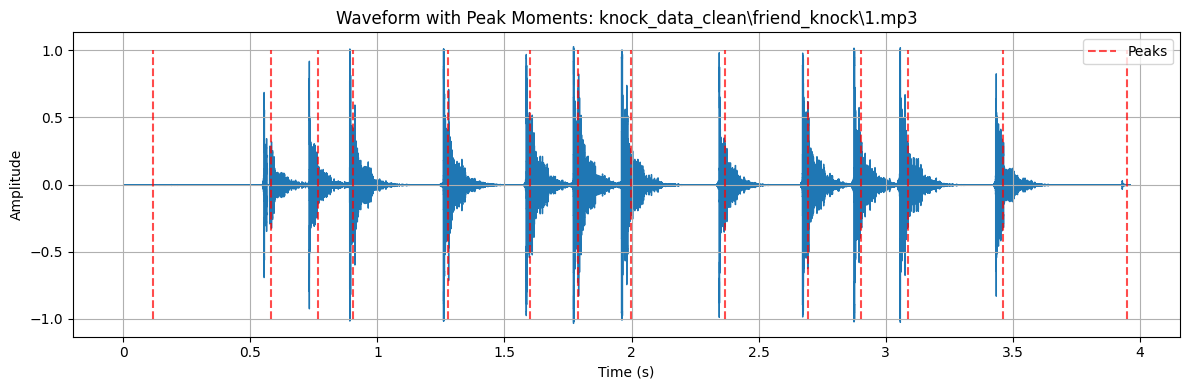

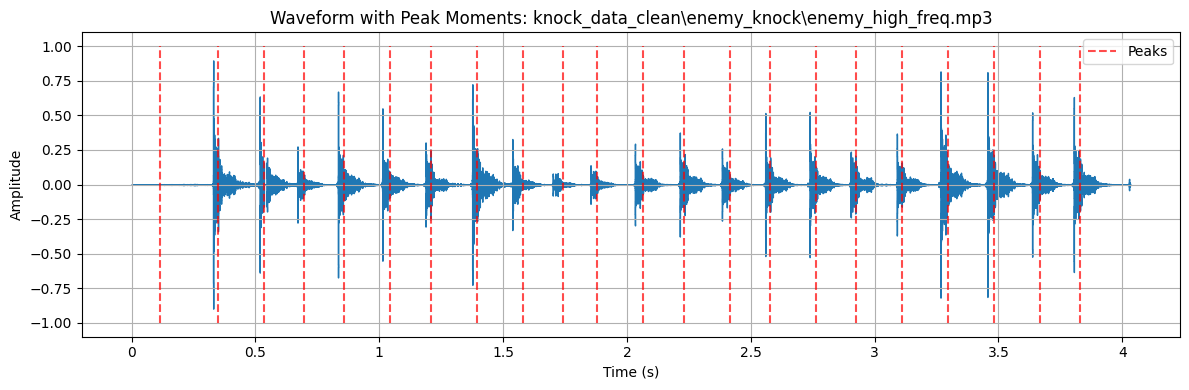

In [27]:
def visualize_peaks_waveform(audio_path, peak_times):
    y, sr = librosa.load(audio_path)

    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.vlines(peak_times, -1, 1, color='r', alpha=0.7, linestyle='--', label='Peaks')
    plt.title(f'Waveform with Peak Moments: {audio_path}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

audio_file = r'knock_data_clean\friend_knock\1.mp3'
peak_times, _ = extract_peaks(audio_file)
visualize_peaks_waveform(audio_file, peak_times)

audio_file = r'knock_data_clean\enemy_knock\enemy_high_freq.mp3'
peak_times, _ = extract_peaks(audio_file)
visualize_peaks_waveform(audio_file, peak_times)

In [28]:
max_len = 0
for f in friendly_features:
    max_len = max(max_len, len(f))
for f in enemy_features:
    max_len = max(max_len, len(f))


padded_friendly_features = [np.pad(f, (0, max_len - len(f))) for f in friendly_features]
friendly_feature_matrix = np.array(padded_friendly_features) if padded_friendly_features else np.empty((0, 0))

padded_enemy_features = [np.pad(f, (0, max_len - len(f))) for f in enemy_features]
enemy_feature_matrix = np.array(padded_enemy_features) if padded_enemy_features else np.empty((0, 0))

enemy_feature_matrix[1]

array([0.        , 0.18211729, 0.36423458, 0.56911654, 0.79676315,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])

In [29]:
distances = euclidean_distances(enemy_feature_matrix, friendly_feature_matrix)
# distances = 1 - cosine_similarity(enemy_feature_matrix, friendly_feature_matrix)
distances

array([[1.35347396, 0.95400476, 1.36785555, 1.36608572, 0.96920071,
        0.97032346, 0.95774008, 0.96242803, 0.96390262, 0.93939211,
        0.96534829, 0.94849938, 0.98463236, 0.9411903 , 0.93221551,
        0.97064509, 0.97138537, 1.31844395, 0.98209811, 0.96320034],
       [2.10564155, 1.93258923, 2.071998  , 2.08427353, 1.75351414,
        1.84333757, 1.82306433, 1.91872045, 1.92909372, 1.94208879,
        1.87011302, 1.86916645, 1.84968207, 1.87195309, 1.85615017,
        1.83018719, 1.87846496, 2.04220868, 1.89568306, 1.87072693],
       [2.32025745, 2.37213208, 2.2991335 , 2.3036759 , 2.31614798,
        2.33806599, 2.33573522, 2.36338299, 2.36731045, 2.39609114,
        2.34784866, 2.35335749, 2.33855665, 2.36176885, 2.35805328,
        2.33583754, 2.35053732, 2.29053116, 2.35833767, 2.35122648],
       [0.88490985, 1.15627218, 0.88279193, 0.88401463, 1.12826879,
        1.14243395, 1.13556915, 1.15370145, 1.15669225, 1.16329252,
        1.14309636, 1.14127129, 1.14427591, 1

In [30]:
min_distances_to_friendly = np.min(distances, axis=1)
max_distances_to_friendly = np.max(distances, axis=1)
mean_distances_to_friendly = np.mean(distances, axis=1)

for i, dist in enumerate(min_distances_to_friendly):
    print(f"*** Enemy Knock {i+1}: ***")
    print(f"Minimum distance to friendly knocks: {dist:.4f}")
    print(f"Maximum distance to friendly knocks: {max_distances_to_friendly[i]:.4f}")
    print(f"Mean distance to friendly knocks: {mean_distances_to_friendly[i]:.4f}")

*** Enemy Knock 1: ***
Minimum distance to friendly knocks: 0.9322
Maximum distance to friendly knocks: 1.3679
Mean distance to friendly knocks: 1.0391
*** Enemy Knock 2: ***
Minimum distance to friendly knocks: 1.7535
Maximum distance to friendly knocks: 2.1056
Mean distance to friendly knocks: 1.9119
*** Enemy Knock 3: ***
Minimum distance to friendly knocks: 2.2905
Maximum distance to friendly knocks: 2.3961
Mean distance to friendly knocks: 2.3429
*** Enemy Knock 4: ***
Minimum distance to friendly knocks: 0.8683
Maximum distance to friendly knocks: 1.1633
Mean distance to friendly knocks: 1.0920
*** Enemy Knock 5: ***
Minimum distance to friendly knocks: 0.8683
Maximum distance to friendly knocks: 1.1633
Mean distance to friendly knocks: 1.0920


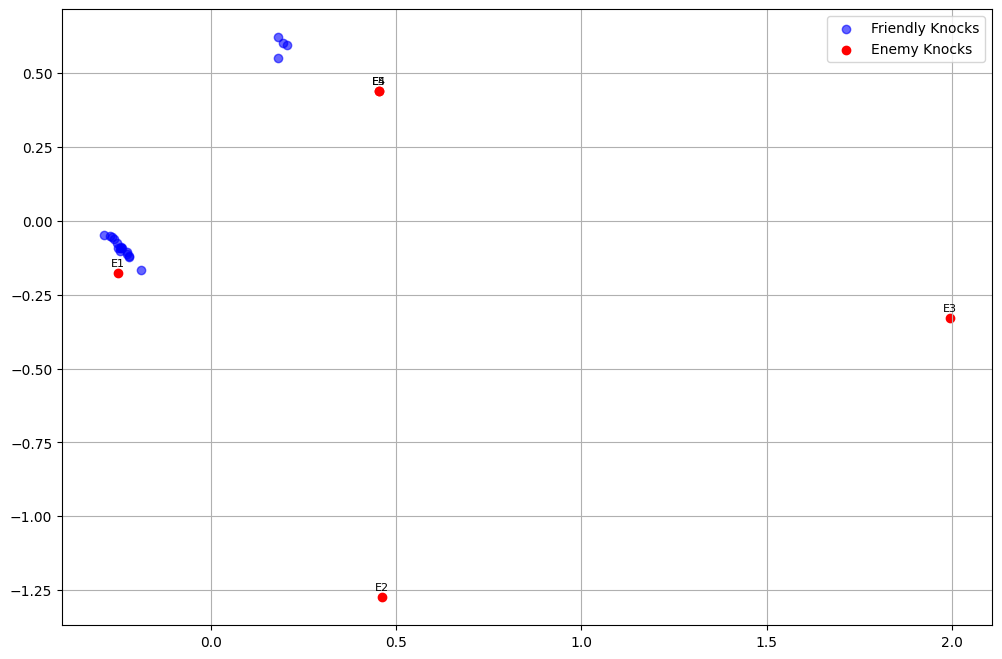

In [31]:
enemy_ids = [f'E{i+1}' for i in range(enemy_feature_matrix.shape[0])]

pca = PCA(n_components=2)
all_features = np.vstack([friendly_feature_matrix, enemy_feature_matrix])
reduced_features_pca = pca.fit_transform(all_features)

num_friendly = friendly_feature_matrix.shape[0]
reduced_friendly = reduced_features_pca[:num_friendly]
reduced_enemy = reduced_features_pca[num_friendly:]

plt.figure(figsize=(12, 8))
plt.scatter(reduced_friendly[:, 0], reduced_friendly[:, 1],
            c='blue', label='Friendly Knocks', alpha=0.6)
plt.scatter(reduced_enemy[:, 0], reduced_enemy[:, 1],
            c='red', label='Enemy Knocks')
for i, txt in enumerate(enemy_ids):
    plt.annotate(txt,(reduced_enemy[i, 0], reduced_enemy[i, 1]),textcoords="offset points",xytext=(0, 5),ha='center',fontsize=8)
plt.legend()
plt.grid(True)
plt.show()